# Auto Regressive Model 



## Auto Regressive Model Example

In [1]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

x = [1, 2, 3, 4, 5, 6, 7]
n = len(x)

mod = ar_select_order(x, maxlag=3, old_names=False)
model = AutoReg(x, lags=mod.ar_lags, old_names=False).fit()
pred = model.predict(start=n, end=n+2)  # zero-based index. 4로 하면 5 가 예측값으로 나옴

print('n                           :', n)
print('selected lags        :',mod.ar_lags)
print('prediction (n:n+2) :', pred)

n                           : 7
selected lags        : [1 2]
prediction (n:n+2) : [ 8.  9. 10.]


# Forecasting Stock Data

## Data

In [2]:
import numpy as np
import pandas as pd
import yfinance
import matplotlib.pylab as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec
from sklearn.metrics import r2_score, mean_squared_error

# Download Stock Data
stock = yfinance.Ticker('035720.KS')
stock = stock.history(period='1y')
stock.index = pd.to_datetime(stock.index)

# Cross Validation
idx = int(len(stock) * 0.7)
train_data, test_data = stock.Close[:idx], stock.Close[idx:]

train_index = train_data.index[:-1]
test_index = test_data.index[:-1]

x_train = train_data.iloc[:-1].values
y_train = train_data.shift(-1).iloc[:-1].values
x_test = test_data.iloc[:-1].values
y_test = test_data.shift(-1).iloc[:-1].values

print(f'train vs test : {len(train_data)} vs {len(test_data)}')
print('x_train:', len(x_train))
print('y_train:', len(y_train))
print('x_test:', len(x_test))
print('y_test:', len(y_test))

train vs test : 174 vs 75
x_train: 173
y_train: 173
x_test: 74
y_test: 74


## Functions

In [3]:
def evaluate(y_train,
             y_test,
             y_train_pred,
             y_test_pred,
             delay_day: int = 1,
             train_index=None,
             test_index=None):
    _y_train_true = pd.Series(y_train, index=train_index)
    _y_train_pred = pd.Series(y_train_pred, index=train_index)

    _y_test_true = pd.Series(y_test, index=test_index)
    _y_test_pred = pd.Series(y_test_pred, index=test_index)

    _train_true_pct = _y_train_true.pct_change().dropna().values
    _train_pred_pct = _y_train_pred.pct_change().dropna().values
    _test_true_pct = _y_test_true.pct_change().dropna().values
    _test_pred_pct = _y_test_pred.pct_change().dropna().values

    hit_train = np.sign(_train_true_pct) == np.sign(_train_pred_pct)
    hit_test = np.sign(_test_true_pct) == np.sign(_test_pred_pct)

    hit_train = hit_train.sum() / hit_train.size
    hit_test = hit_test.sum() / hit_test.size

    df = pd.DataFrame(
        {
            'r2_score': [
                r2_score(_y_train_true, _y_train_pred),
                r2_score(_y_test_true, _y_test_pred)
            ],
            'root_mean_sqaured': [
                mean_squared_error(y_train, y_train_pred, squared=False),
                mean_squared_error(y_test, y_test_pred, squared=False)
            ],
            'hit': [hit_train, hit_test]
        },
        index=['train', 'test']).round(3)
    display(df)

    fig = plt.figure(constrained_layout=True, figsize=(9, 6))
    gs = fig.add_gridspec(ncols=2, nrows=3)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(_y_train_true, color='blue', label='y_true')
    ax1.plot(_y_train_pred, color='red', label='y_pred')
    ax1.set_title('Train')
    ax1.legend()

    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(_y_test_true, color='blue', label='y_true')
    ax2.plot(_y_test_pred, color='red', label='y_pred')
    ax2.set_title('Test')
    ax2.legend()

    ax3 = fig.add_subplot(gs[2, 0])
    sns.regplot(x=_train_true_pct, y=_train_pred_pct, ax=ax3)
    sns.despine(ax=ax3, offset=0)
    ax3.axhline(y=0, color='tomato')
    ax3.axvline(x=0, color='tomato')
    ax3.set_xlabel('Observations')
    ax3.set_ylabel('Predictions')

    ax4 = fig.add_subplot(gs[2, 1])
    sns.regplot(x=_test_true_pct, y=_test_pred_pct, ax=ax4)
    sns.despine(ax=ax4, offset=0)
    ax4.axhline(y=0, color='tomato')
    ax4.axvline(x=0, color='tomato')
    ax4.set_xlabel('Observations')
    ax4.set_ylabel('Predictions')


## Base Forecasting 

그냥 바로 전의 데이터를 예측된 y값으로 사용함. <br>
이걸 뛰어넘는게 중요

 - 3, 4번째 그래프를 보면, regression 그래프를 그려놨는데.. 전혀 선형적이지 않음. 

,r2_score,root_mean_sqaured,hit
train,0.974,1762.292,0.506
test,0.955,2348.979,0.493


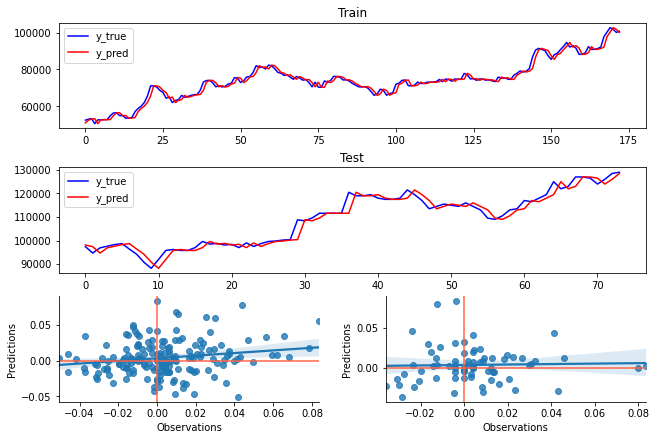

In [4]:
y_train_pred = x_train
y_test_pred = x_test

evaluate(y_train, y_test, y_train_pred, y_test_pred)

## Auto Regressive Model for Stock

 - Train Hit: 2.3% 상승 
 - Test Hit : -13% 나락
 
 결론: 안됨  ㅎㅎ  <br> 
 AR 모델은 linear model 임. 하지만 주식은 non-linear 데이터 -> 그래서 안됨
 
<small style="color:#777777">* 참고로 AR모델링은 cross validation이 의미가 없음. 할때마다 학습하고 predict해야 함</small>

start_idx: 6 mod.ar_lags: [1 2]
start_idx: 5 mod.ar_lags: [1]


,r2_score,root_mean_sqaured,hit
train,0.923,2835.170,0.512
test,0.885,3699.914,0.426


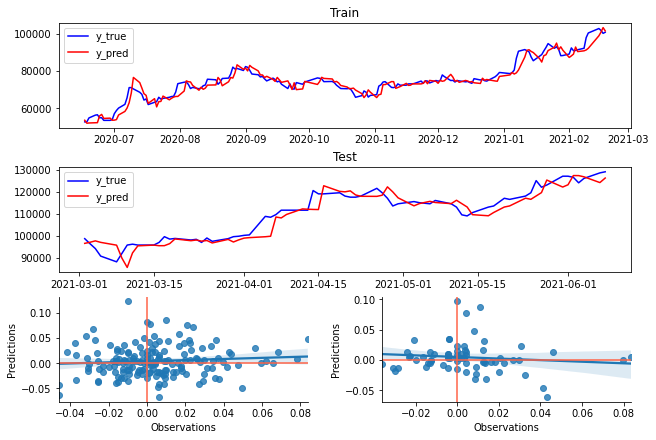

In [5]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def ar_predict(series: np.array):
    mod = ar_select_order(series, maxlag=12, old_names=False)
    start_idx = mod.ar_lags.max() + 4
    print('start_idx:', start_idx, 'mod.ar_lags:', mod.ar_lags)

    y_pred = list()
    for i in range(start_idx, len(series)):
        model = AutoReg(series[:i], lags=mod.ar_lags, old_names=False).fit()
        _y = model.predict(start=i, end=i)    
        y_pred.append(_y)
    return np.array(y_pred).reshape(-1), mod

y_train_pred, mod_train = ar_predict(x_train)
y_test_pred, mod_test = ar_predict(x_test)

i = mod_train.ar_lags.max() + 4
j = mod_test.ar_lags.max() + 4

evaluate(y_train[i:], y_test[j:], y_train_pred, y_test_pred, 
         train_index=train_index[i:], 
         test_index=test_index[j:])

## AR Model with Decomposition